In [ ]:
# Thanks to mjdietzx for Keras code for ResNet (see section below)

In [1]:
# Setup
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
import Utils.PokemonPlot as pp
import Utils.PokemonModelUtils as pmu
from matplotlib import pyplot as plt
import importlib
from keras.callbacks import ModelCheckpoint

utils = pkmnUtils.PokemonUtils(rel_loc="")

# Only run if split file has not already been generated
if False:
    utils.loadAllGIFs()
    utils.generateXYSplitsV2(outFile="Data/SplitsV2")

utils.localLoadAllGifs("Data/SplitsV2.npz")
    
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

USE_GPU = True
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)


In [ ]:
# Run on PokemonUtils update
import Utils.PokemonUtils as pkmnUtils
importlib.reload(pkmnUtils)  # update import if PokemonUtils.py changes
utils = pkmnUtils.PokemonUtils(utils=utils)

In [2]:
x_train_m = x_train.astype('float32') 
x_val_m = x_val.astype('float32') 
x_test_m = x_test.astype('float32')
y_train_m = y_train
y_val_m = y_val
y_test_m = y_test

# display these images (range 0-1 necessary for imshow)
x_train_i = (x_train_m) / 255
x_val_i   = (x_val_m)   / 255
x_test_i  = (x_test_m)  / 255

x_mean = np.mean(x_train_m)
x_train_m = (x_train_m - x_mean) / 255
x_val_m   = (x_val_m - x_mean)   / 255
x_test_m  = (x_test_m - x_mean)  / 255

x_train_s = x_train_m[::10]
x_val_s   = x_val_m[::10]
x_test_s  = x_test_m[::10]
y_train_s = y_train_m[::10]
y_val_s   = y_val_m[::10]
y_test_s  = y_test_m[::10]

print("Data normalization:")
print("mean:", x_mean)
print("max: ", np.max(x_train_m))
print("min: ", np.min(x_train_m))
print("Data shapes:")
print("x_train_m:", x_train_m.shape)
print("x_val_m:  ", x_val_m.shape)
print("x_test_m: ", x_test_m.shape)
print("y_train_m:", y_train_m.shape)
print("y_val_m:  ", y_val_m.shape)
print("y_test_m: ", y_test_m.shape)
print("x_train_s:", x_train_s.shape)
print("x_val_s:  ", x_val_s.shape)
print("x_test_s: ", x_test_s.shape)
print("y_train_s:", y_train_s.shape)
print("y_val_s:  ", y_val_s.shape)
print("y_test_s: ", y_test_s.shape)

Data normalization:
mean: 26.629704
max:  0.8955698
min:  -0.10443021
Data shapes:
x_train_m: (6010, 128, 128, 4)
x_val_m:   (1510, 128, 128, 4)
x_test_m:  (1880, 128, 128, 4)
y_train_m: (6010,)
y_val_m:   (1510,)
y_test_m:  (1880,)
x_train_s: (601, 128, 128, 4)
x_val_s:   (151, 128, 128, 4)
x_test_s:  (188, 128, 128, 4)
y_train_s: (601,)
y_val_s:   (151,)
y_test_s:  (188,)


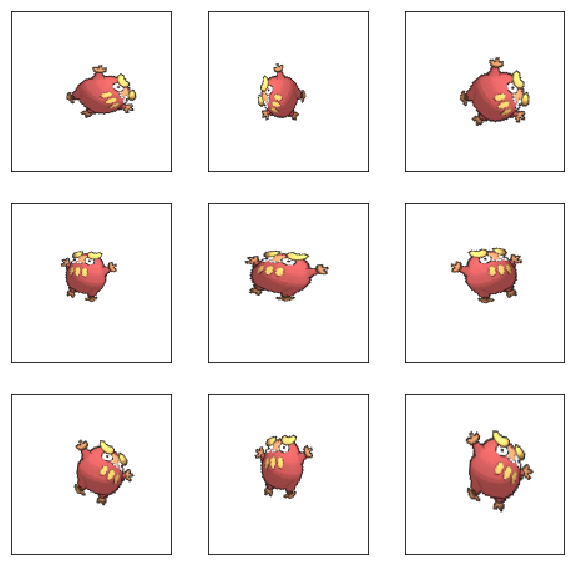

In [3]:
# Functions / objects necessary to train a model
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.color as color

def oneHot(y, cols=None):
    if (cols < 1):
        cols = np.max(y)
    n = y.shape[0]
    z = np.zeros((n, cols))
    z[np.arange(n), (y-1)] = 1
    return z


data_aug = ImageDataGenerator(
    rotation_range=50,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

image = x_train_i[0,:,:,:]
image = image.reshape((1,) + image.shape)

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,3)

i = 0
for batch in data_aug.flow(image, batch_size=1):
    ax = plt.subplot(gs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(batch[0])
    i += 1
    if i >= 9:
        break

In [4]:
"""
ResNet implementation based on:
https://gist.github.com/mjdietzx/0cb95922aac14d446a6530f87b3a04ce

"""

from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers

img_height = 128
img_width = 128
img_channels = 4

def residual_network(x, deep, wide, regularizer=None):
    cardinality = 1
    if wide:
        cardinality = 32
    
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same', kernel_regularizer=regularizer)(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same', kernel_regularizer=regularizer)(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_regularizer=regularizer)(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_regularizer=regularizer)(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same', kernel_regularizer=regularizer)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_regularizer=regularizer)(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        x = residual_block(x, 128, 256, _project_shortcut=(i == 0))

    if deep:
        # conv3
        for i in range(4):
            # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
            strides = (2, 2) if i == 0 else (1, 1)
            x = residual_block(x, 256, 512, _strides=strides)
        
        if deep > 1:
            # conv4
            for i in range(6):
                strides = (2, 2) if i == 0 else (1, 1)
                x = residual_block(x, 512, 1024, _strides=strides)

            # conv5
            for i in range(3):
                strides = (2, 2) if i == 0 else (1, 1)
                x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(18, activation='softmax', kernel_regularizer=regularizer)(x)

    return x

def getResidualModel(deep=False, wide=True, regularizer=None):
    image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
    network_output = residual_network(image_tensor, deep, wide, regularizer=regularizer)

    model = models.Model(inputs=[image_tensor], outputs=[network_output])
    return model

In [87]:
reg_vals = [0.1, 0.03, 0.01, 0.003, 0.001]

lr_vals = [0.0003]#[0.003, 0.001, 0.0003]
batch_sizes = [32]#[16, 32, 64]

print("Starting hyperparameter search")
model_list = []
history_list = []
for reg in reg_vals:
    print("New reg")
    for lr in lr_vals:
#         print("\tNew lr")
        for bs in batch_sizes:
#             print("\t\tNew bs")
            model = getResidualModel(deep=0, regularizer=regularizers.l2(lr))
            model.compile(optimizer=optimizers.Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
            
            history = model.fit_generator(
                data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=bs),
                epochs=10,
                verbose=1,
                callbacks=[],
                validation_data=(x_val_m, oneHot(y_val_m, 18)),
            )
            model_list.append(model)
            history_list.append(history)
            
#         _models.append(__models)
#         _histories.append(__histories)
        
#     model_list.append(_models)
#     history_list.append(_histories)

Starting hyperparameter search
New reg


KeyboardInterrupt: 

In [84]:
i = 0
m = model_list[0][0][0]
for a in range(3):
    for b in range(3):
        print("Model %d" %(3 * a + b))
        m = model_list[0][a][b]
        pred_train_m = m.predict(x_train_m)
        pred_val_m = m.predict(x_val_m)
        train_acc, train_acc_2, train_avg_scores = customPredict(pred_train_m, y_train_m[::10], y2=y_train_2[::10])
        val_acc, val_acc_2, val_avg_scores = customPredict(pred_val_m, y_val_m[::10], y2=y_val_2[::10])
        print("\tTrain accuracy primary:       ", train_acc)
        print("\tTrain accuracy secondary:     ", train_acc_2)
        print("\tValidation accuracy primary:  ", val_acc)
        print("\tValidation accuracy secondary:", val_acc_2) 

Model 0
	Train accuracy primary:        0.33777038269550747
	Train accuracy secondary:      0.37271214642262895
	Validation accuracy primary:   0.2185430463576159
	Validation accuracy secondary: 0.25165562913907286
Model 1
	Train accuracy primary:        0.15806988352745424
	Train accuracy secondary:      0.18469217970049917
	Validation accuracy primary:   0.10596026490066225
	Validation accuracy secondary: 0.12582781456953643
Model 2
	Train accuracy primary:        0.2512479201331115
	Train accuracy secondary:      0.26455906821963393
	Validation accuracy primary:   0.1986754966887417
	Validation accuracy secondary: 0.23841059602649006
Model 3
	Train accuracy primary:        0.35108153078202997
	Train accuracy secondary:      0.37437603993344426
	Validation accuracy primary:   0.2185430463576159
	Validation accuracy secondary: 0.23841059602649006
Model 4
	Train accuracy primary:        0.5074875207986689
	Train accuracy secondary:      0.5374376039933444
	Validation accuracy primary: 

In [6]:
model = getResidualModel(deep=1, regularizer=regularizers.l2(0.01))
model.compile(optimizer=optimizers.Adam(lr=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Training
batch_size = 32

history = model.fit_generator(
    data_aug.flow(x_train_m, oneHot(y_train_m, 18), batch_size=batch_size),
    epochs=30,
    verbose=1,
    callbacks=[],
    validation_data=(x_val_m, oneHot(y_val_m, 18)),
)

Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[32,256,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_277/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](max_pooling2d_2/MaxPool, conv2d_277/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics/acc/Mean/_7611 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_39494_metrics/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d_277/convolution', defined at:
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shared/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/shared/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/shared/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-ae0e5255ea2a>", line 1, in <module>
    model = getResidualModel(deep=1, regularizer=regularizers.l2(0.01))
  File "<ipython-input-4-7b82055714bd>", line 116, in getResidualModel
    network_output = residual_network(image_tensor, deep, wide, regularizer=regularizer)
  File "<ipython-input-4-7b82055714bd>", line 89, in residual_network
    x = residual_block(x, 128, 256, _project_shortcut=(i == 0))
  File "<ipython-input-4-7b82055714bd>", line 71, in residual_block
    shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same', kernel_regularizer=regularizer)(shortcut)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3335, in conv2d
    data_format=tf_data_format)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 782, in convolution
    return op(input, filter)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 870, in __call__
    return self.conv_op(inp, filter)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 522, in __call__
    return self.call(inp, filter)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 206, in __call__
    name=self.name)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 953, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,256,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d_277/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](max_pooling2d_2/MaxPool, conv2d_277/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: metrics/acc/Mean/_7611 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_39494_metrics/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



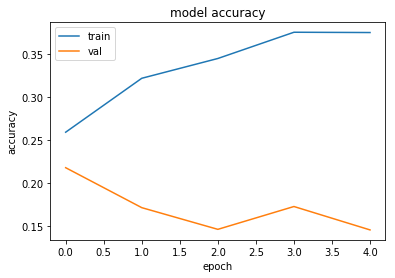

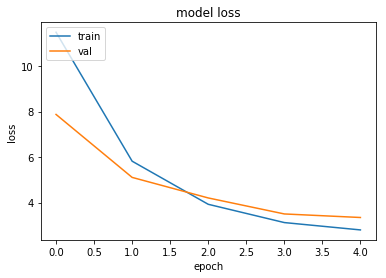

In [68]:
# list all data in history
h = history.history

# summarize history for accuracy
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [96]:
model.save("./Models/residual_deepreg_model1.hdf5")

In [48]:
model.load_weights("./Models/residual_normal_model1.hdf5")

In [97]:
pred_train_m = model.predict(x_train_m)
print('Done!')
pred_val_m = model.predict(x_val_m)
print('Done!')

Done!
Done!


In [10]:
# Get secondary typing 
y_train_2, y_val_2, y_test_2 = utils.getSecondaryTypeLabels()

# Define fn to average scores across frames of pokemon's animation
def customPredict(scores, y, y2=None, frames=10):
    # Averaging
    N, T = scores.shape
    scores_reshaped = scores.reshape((N//10, 10, T))
    avg_scores = np.mean(scores_reshaped, axis=1)
    
    # Primary accuracy
    predictions = np.argmax(avg_scores, axis=1)
    matches = predictions == y-1  # y is 1-indexed
    acc1 = np.sum(matches)/len(matches)
    
    acc2 = None
    if y2 is not None:
        matches2 = predictions == y2-1
        acc2 = np.sum(matches + matches2)/len(matches)  # + acts as an or operator
    
    # Dual accuracy
    return (acc1, acc2, avg_scores)

y_train_2: (6010,)
y_val_2:   (1510,)
y_test_2:  (1880,)


In [98]:
train_acc, train_acc_2, train_avg_scores = customPredict(pred_train_m, y_train_m[::10], y2=y_train_2[::10])
val_acc, val_acc_2, val_avg_scores = customPredict(pred_val_m, y_val_m[::10], y2=y_val_2[::10])
print("Train accuracy primary:       ", train_acc)
print("Train accuracy secondary:     ", train_acc_2)
print("Validation accuracy primary:  ", val_acc)
print("Validation accuracy secondary:", val_acc_2)

Train accuracy primary:        0.6089850249584027
Train accuracy secondary:      0.6339434276206323
Validation accuracy primary:   0.18543046357615894
Validation accuracy secondary: 0.2251655629139073


In [7]:
import Utils.PokemonPlot as pp
importlib.reload(pp)  # update import for changes

SyntaxError: invalid syntax (PokemonPlot.py, line 4)

In [40]:
start = 300  # start index
num = 10    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")

pp.plotPredictions(x_train_i[start*step:(start+num)*step:step],
                   y_train_m[start*step:(start+num)*step:step],
                   train_avg_scores[start:start+num:1], k=5, y2=y_train_2[start*step:(start+num)*step:step])

Train predictions


Validation predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

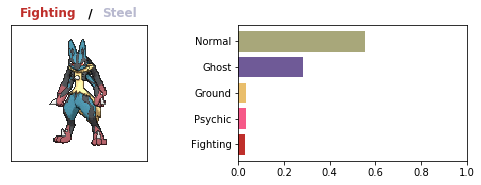

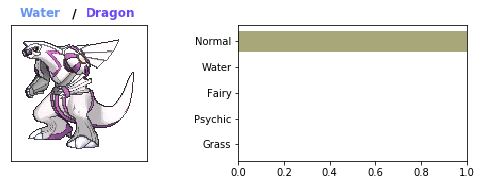

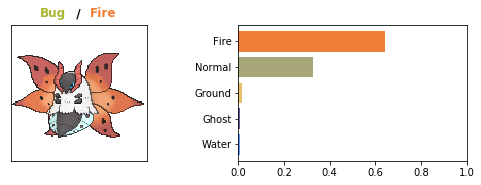

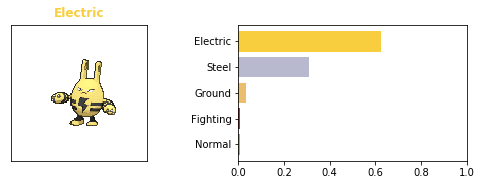

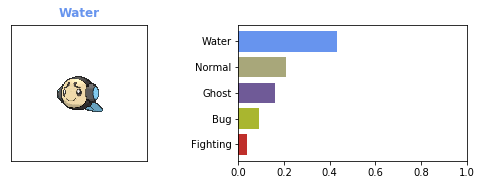

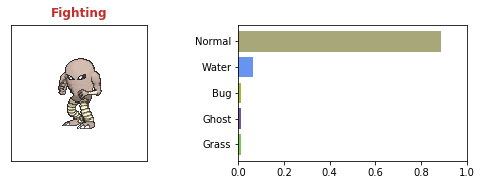

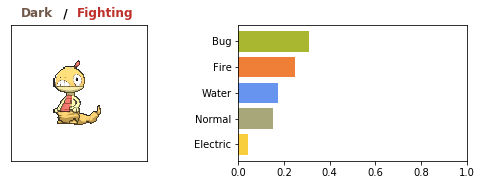

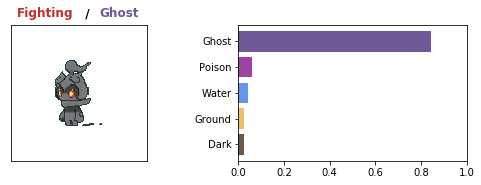

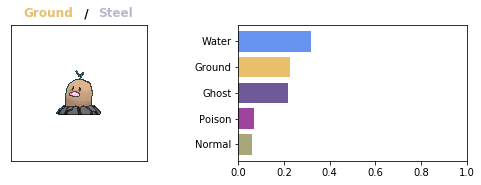

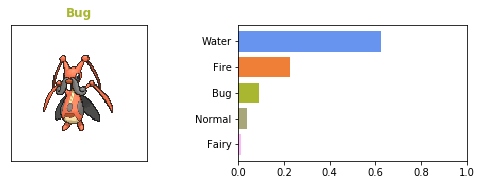

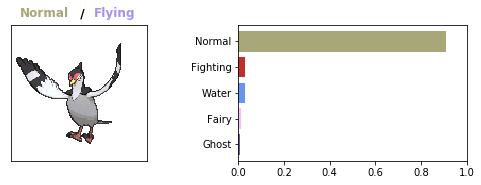

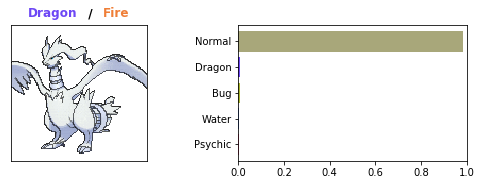

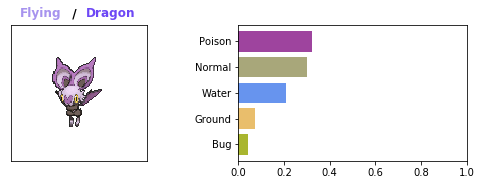

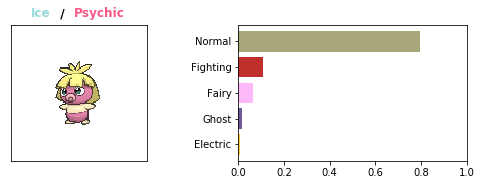

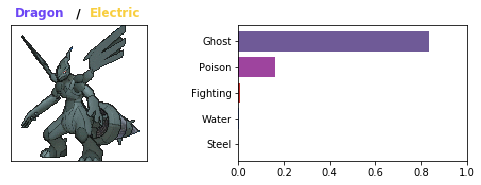

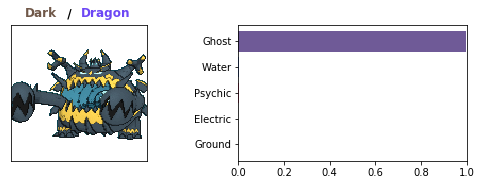

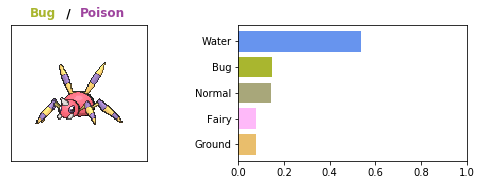

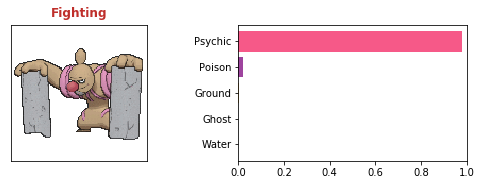

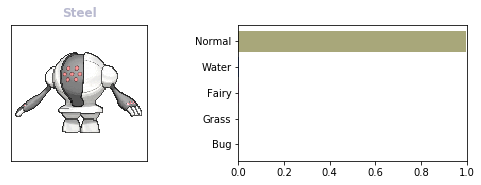

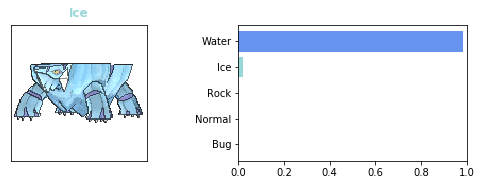

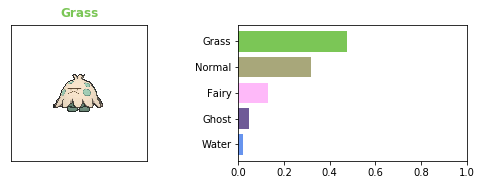

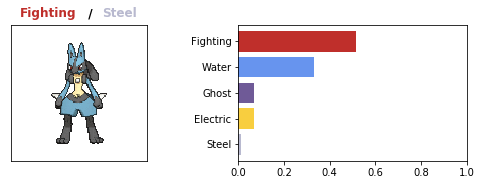

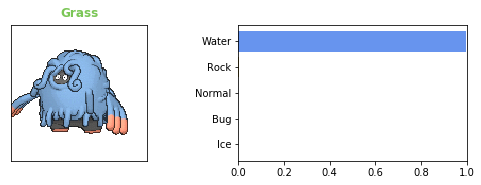

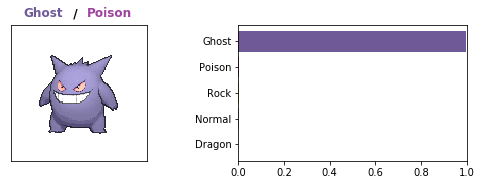

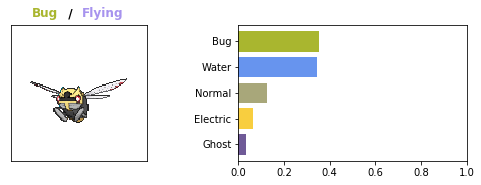

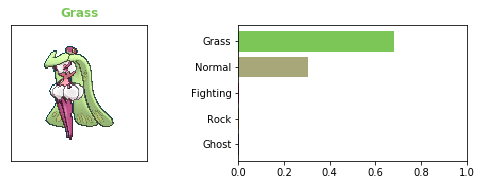

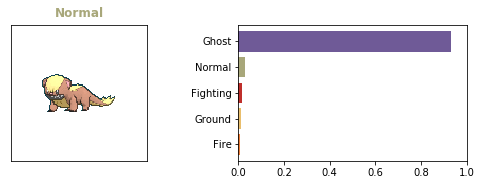

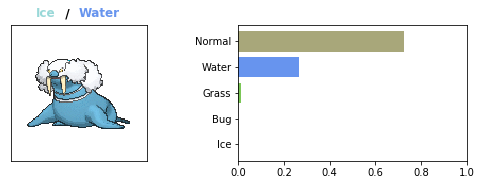

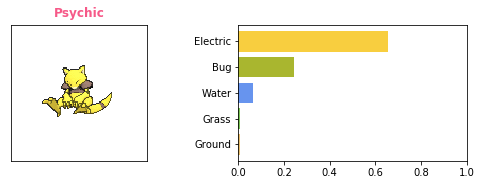

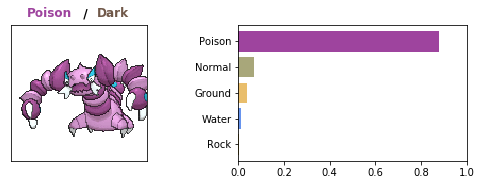

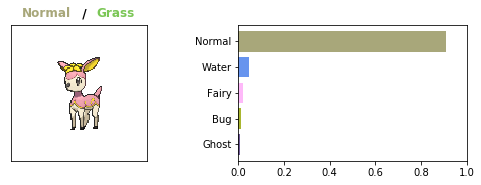

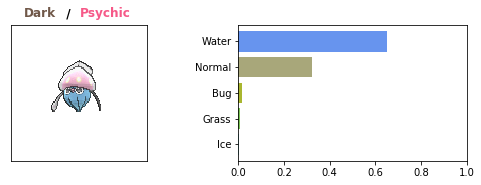

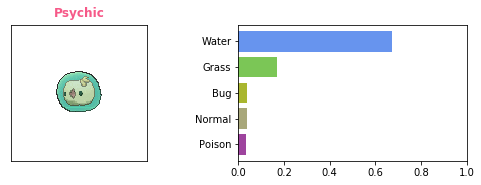

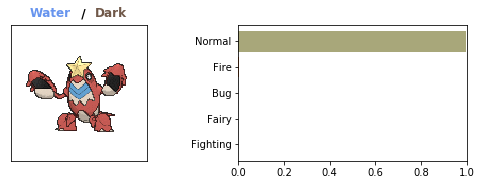

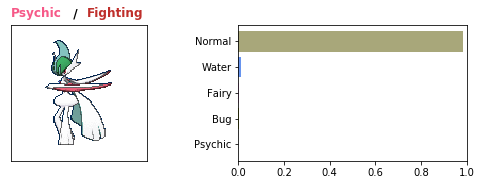

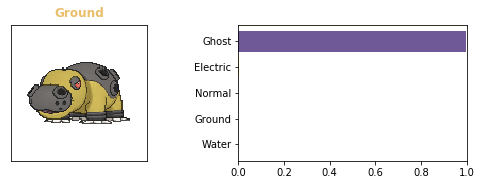

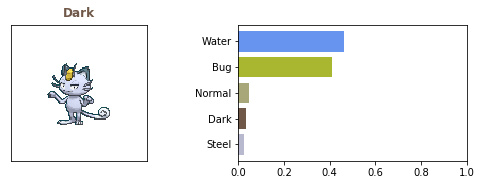

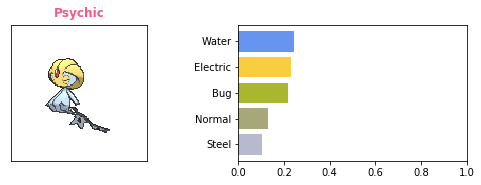

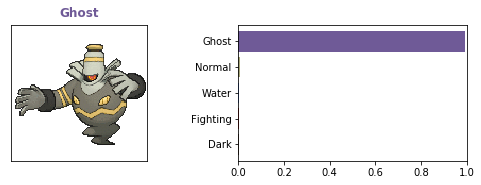

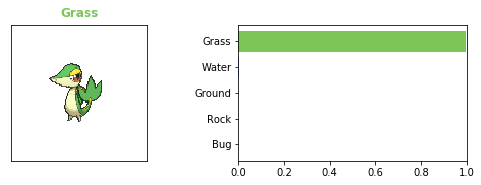

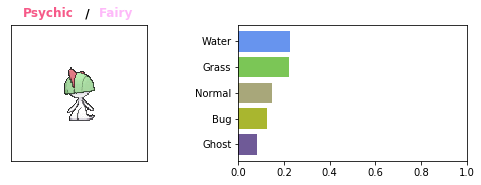

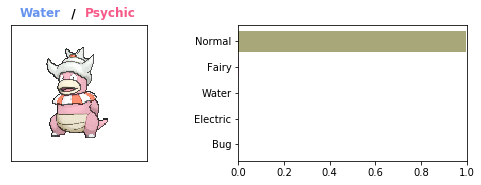

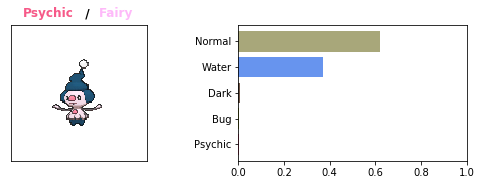

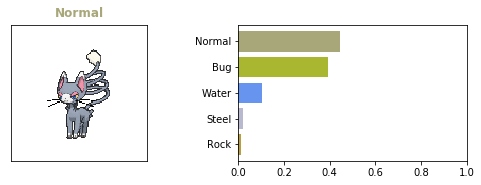

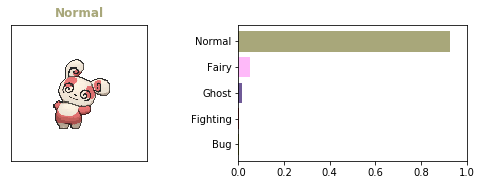

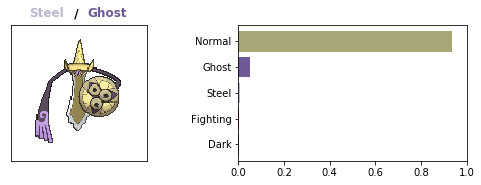

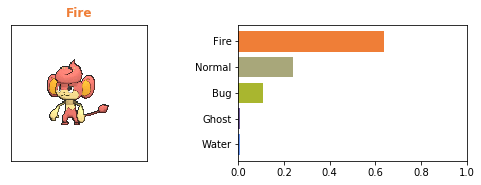

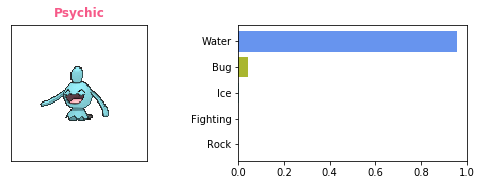

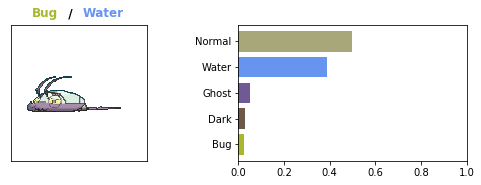

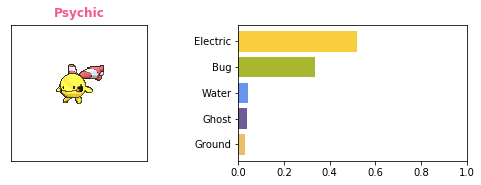

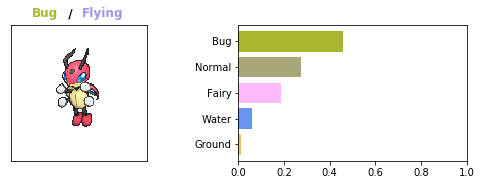

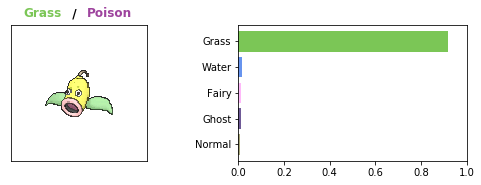

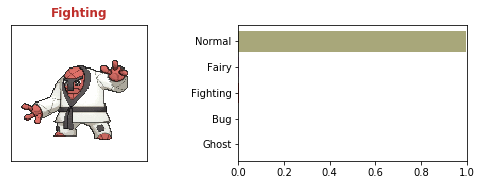

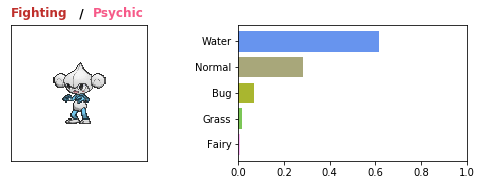

In [41]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Validation predictions")
pp.plotPredictions(x_val_i[start*step:(start+num)*step:step],
                   y_val_m[start*step:(start+num)*step:step],
                   val_avg_scores[start:start+num:1], k=5, y2=y_val_2[start*step:(start+num)*step:step])

In [1]:
# from Utils import PokemonModelUtils

for version in ['residual_normal', 'residual_deep', 'residual_deepreg']:
    model.load_weights("./Models/" + version + "_model1.hdf5")
    print("Version:", version)
    print("Making predictions")
    pred_train_m = model.predict(x_train_m)
    pred_val_m = model.predict(x_val_m)
    pred_test_m = model.predict(x_test_m)
    
    metrics_train = custom_predict(pred_train_m, y_train_m, y2=y_train_2)
    metrics_val = custom_predict(pred_val_m, y_val_m, y2=y_val_2)
    metrics_test = custom_predict(pred_test_m, y_test_m, y2=y_test_2)
    
    titles = ["Train", "Val", "Test"]
    mets = {"Train": metrics_train, "Val": metrics_val, "Test": metrics_test}
    for title in titles:
        print(title)
        cur_metric = mets[title]
        for k in cur_metric.keys():
            if k not in ["avg_scores", "avg_predictions", "predictions", "confusion_mat"]:
                print(k + ":\t", cur_metric[k])
        pp.plotConfusionMatrix(cur_metric["confusion_mat"], "CNN " + title)
        print()
        
    

NameError: name 'model' is not defined

Models generated
Version: residual_normal
Making predictions


/home/benjaminshare/pokemon-learning/Utils/PokemonModelUtils.py:44: RuntimeWarning: invalid value encountered in true_divide
  avg_recall    = np.nanmean(true_pos / (true_pos + false_neg))


Train
acc:	 0.5317803660565724
avg_acc:	 0.5357737104825291
avg_acc_2:	 0.5457570715474209
avg_precision:	 0.4090643416603604
avg_recall:	 0.8005824570985252

Val
acc:	 0.30596026490066225
avg_acc:	 0.31788079470198677
avg_acc_2:	 0.3576158940397351
avg_precision:	 0.24355796899656548
avg_recall:	 0.36042058786624004

Test
acc:	 0.2781914893617021
avg_acc:	 0.2765957446808511
avg_acc_2:	 0.2925531914893617
avg_precision:	 0.17742374727668844
avg_recall:	 0.21117283950617285

Version: residual_deep
Making predictions
Train
acc:	 0.9028286189683861
avg_acc:	 0.9034941763727121
avg_acc_2:	 0.9051580698835274
avg_precision:	 0.8930125604992766
avg_recall:	 0.9401297256662412

Val
acc:	 0.2721854304635762
avg_acc:	 0.2781456953642384
avg_acc_2:	 0.2980132450331126
avg_precision:	 0.25093507188450426
avg_recall:	 0.23703347793131074

Test
acc:	 0.32180851063829785
avg_acc:	 0.32978723404255317
avg_acc_2:	 0.3617021276595745
avg_precision:	 0.246171802054155
avg_recall:	 0.3277077497665733

V

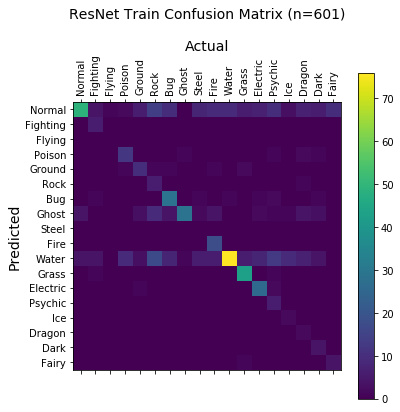

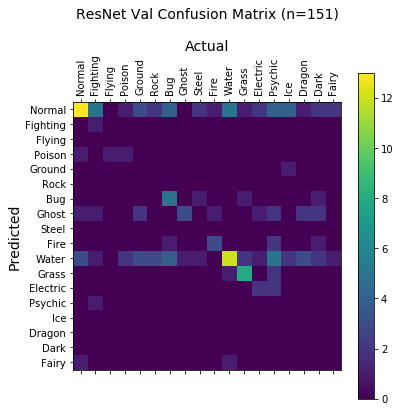

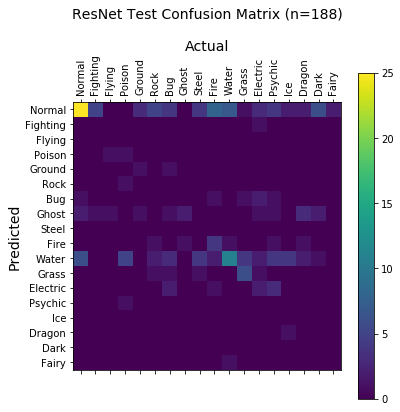

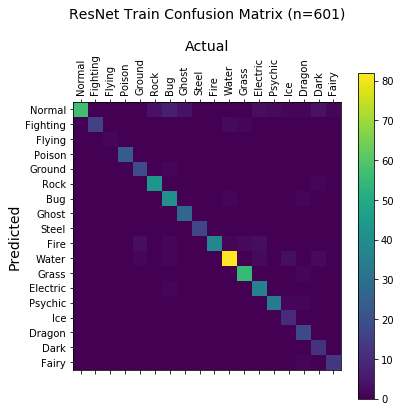

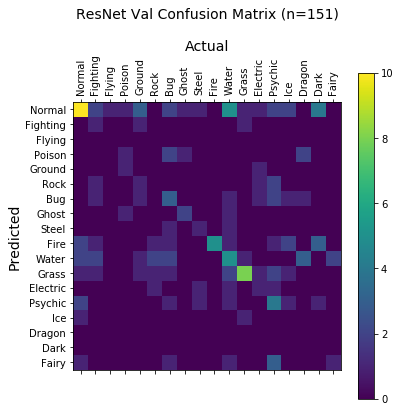

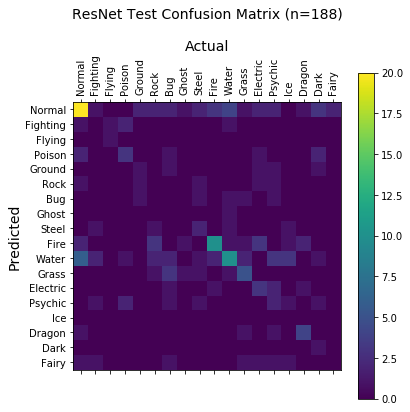

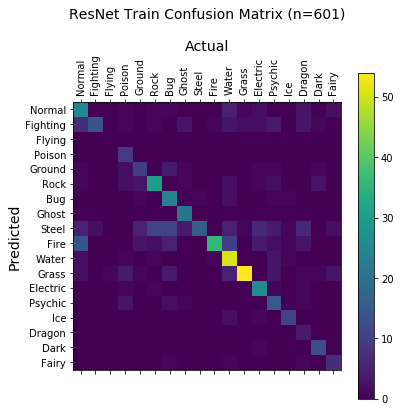

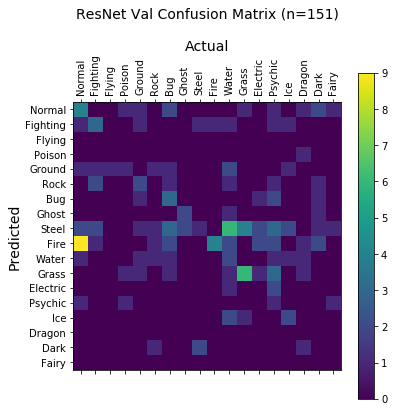

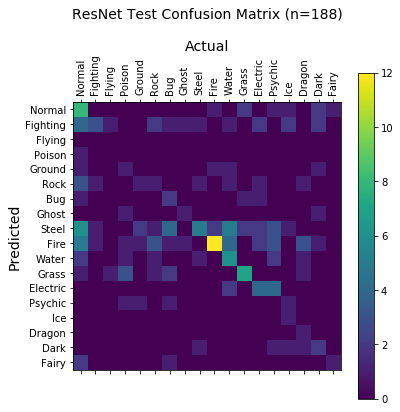

In [15]:
model = getResidualModel(deep=1, regularizer=regularizers.l2(0.01))
model.compile(optimizer=optimizers.Adam(lr=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model0 = getResidualModel(deep=0)
model1 = getResidualModel(deep=1)
model2 = getResidualModel(deep=1, regularizer=regularizers.l2(0.01))

model0.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model1.compile(optimizer="Adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.compile(optimizer=optimizers.Adam(lr=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_list = [model0, model1, model2]
i = 0

print("Models generated")
for version in ['residual_normal', 'residual_deep', 'residual_deepreg']:
    model = model_list[i]
    i += 1
    model.load_weights("./Models/" + version + "_model1.hdf5")
    print("Version:", version)
    print("Making predictions")
    pred_train_m = model.predict(x_train_m)
    pred_val_m = model.predict(x_val_m)
    pred_test_m = model.predict(x_test_m)
    
    metrics_train = pmu.customPredict(pred_train_m, y_train_m, y2=y_train_2)
    metrics_val = pmu.customPredict(pred_val_m, y_val_m, y2=y_val_2)
    metrics_test = pmu.customPredict(pred_test_m, y_test_m, y2=y_test_2)
    
    titles = ["Train", "Val", "Test"]
    mets = {"Train": metrics_train, "Val": metrics_val, "Test": metrics_test}
    for title in titles:
        print(title)
        cur_metric = mets[title]
        for k in cur_metric.keys():
            if k not in ["avg_scores", "avg_predictions", "predictions", "confusion_mat"]:
                print(k + ":\t", cur_metric[k])
        pp.plotConfusionMatrix(cur_metric["confusion_mat"], "ResNet " + title)
        print()